# Setup

In [129]:
import pandas as pd  # Data handling
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
from pyvbmc import VariationalPosterior
from pyvbmc.priors import SplineTrapezoidal
from scipy.optimize import minimize
import scipy.stats as scs

# Differential equation to be solved
def diffyqs(X, t, a, b):
    x, vx = X[0], X[1]
    dx = vx
    dv = -x - np.sign(x) * a * np.abs(x)**b
    return [dx, dv]

# time array for solution
dt = 0.05
tf = 10
t = np.arange(0,tf,dt)

# Range of values that parameters can take on
a_min = 0.0
a_max = 0.5
b_min = 1.0
b_max = 5.0

# Number of parameters (dimension)
D = 2

# Bounds for VBMC object (LB and UB expanded a bit beyond what the actual true values could be)
LB = np.full((1, D), a_min)
LB[0][0] = a_min
LB[0][1] = b_min - 1
UB = np.full((1, D), a_max)
UB[0][0] = a_max + 0.1
UB[0][1] = b_max + 1
PLB = np.copy(LB)
PLB[0][0] = a_min + 0.01
PLB[0][1] = b_min
PUB = np.copy(UB)
PUB[0][0] = a_max 
PUB[0][1] = b_max

# pick a random starting point and do initial minimizatio on it
np.random.seed(4) # leave this
x0_rand = np.random.uniform(PLB, PUB)

#set up prior
prior = SplineTrapezoidal(LB, PLB, PUB, UB)
options = {
    "display": "off"
}

vbmc_count = 0 

print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0_rand:',x0_rand)

LB: [[0. 0.]] PLB: [[0.01 1.  ]] PUB: [[0.5 5. ]] UB: [[0.6 6. ]] x0_rand: [[0.48384462 3.188929  ]]


designing a new log liklihood:

In [130]:
# pick some nice parameter values to investigate (nonlinear corners and a point in the middle)
a_vals = [0.06,0.06,0.5,0.5,0.28]
b_vals = [1.44,5.0,1.44,5.0,3.22]

initial_conditions = [[0.0, 3.5],[2.0, 0.0],[-0.5, -0.5],[3.14, -0.3]]

# gaussian-ish log_likelihood
def log_likelihood(theta):
    a,b = theta
    sols = []
    sigma = 0.1
    for initial_condition in initial_conditions:
        sols.append(odeint(diffyqs, initial_condition, t, args=(a,b))[:,1])

    big_sol = np.concatenate(sols)
    sliced_sol = big_sol[0::4]

    return np.sum(np.log(1/(sigma * (2*np.pi)**0.5)) - (0.5/sigma**2) * (sliced_sol - noisy_sliced_sol)**2)

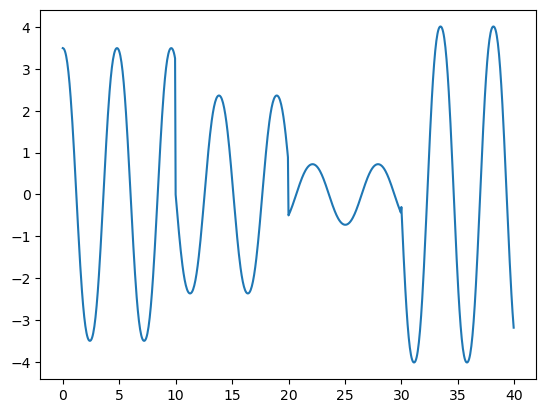

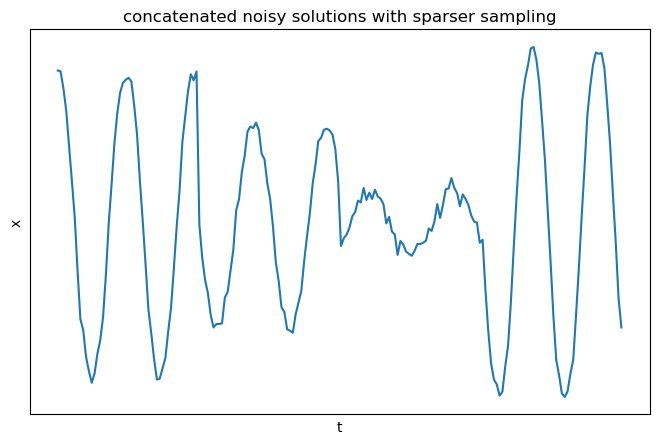

In [200]:
a = 0.3
b = 2.0
sols = []
sigma = 0.1
for initial_condition in initial_conditions:
    sols.append(odeint(diffyqs, initial_condition, t, args=(a,b))[:,1])

sigma = 0.12
big_t = np.arange(0,4*tf,dt )#np.concatenate([t for i in range(4)])
big_sol = np.concatenate(sols)
sliced_sol = big_sol[0::4]
noisy_sliced_sol = sliced_sol + sigma * np.random.randn(len(sliced_sol))

import matplotlib.pyplot as plt
plt.plot(big_t,big_sol)

plt.show()

plt.figure(figsize=(8,5))
plt.plot(noisy_sliced_sol)
plt.title("concatenated noisy solutions with sparser sampling")
plt.xticks([])
plt.yticks([])
plt.ylabel('x')
plt.xlabel('t')
plt.show()

# Running and saving

In [146]:
param_list = []
seeds = [0,3]
vbmc_count = 0
for nut in seeds:
    vbmc_count = 0
    for i,a in enumerate(a_vals): 
        b = b_vals[i]    
        param_list.append([a,b])

        # get truth
        sols = []
        for initial_condition in initial_conditions:
            sols.append(odeint(diffyqs, initial_condition, t, args=(a,b))[:,1])

        sigma = 0.12
        big_sol = np.concatenate(sols)
        sliced_sol = big_sol[0::4]
        noisy_sliced_sol = sliced_sol + sigma * np.random.randn(len(sliced_sol))
        
        # Do initial optimization to get an x0
        np.random.seed(nut) # change this
        x0 = minimize(
            lambda t: -log_likelihood(t),
            x0_rand,
            bounds=[
                (a_min, a_max),
                (b_min, b_max),
            ],
        ).x

        # run vbmc and save results
        np.random.seed(nut) # and this
        vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options)
        np.random.seed(nut) # and this
        vp, results = vbmc.optimize();
        vbmc.vp.save("vp" + str(vbmc_count) + str(nut) + ".pkl", overwrite=True)
        vbmc_count += 1

# save parameter values
#np.savetxt("param_values.csv", np.array(param_list))

C:\Users\walki\AppData\Local\Temp\ipykernel_20224\2228172326.py:21: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  x0 = minimize(


Reshaping x0 to row vector.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: 120.518 +/-0.000.
Reshaping x0 to row vector.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 1. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 6. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 2. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 3. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: 100.148 +/-0.126.
Caution: Returned variational solution may have not converged.
Reshaping x0 to row vector.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 4. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: 145.363 +/-0.000.
Reshaping x0 to row vector.
vbmc:InitialPointsTooClosePB: The starting points X0 are on or numerically too close to the hard bounds LB and UB. Moving the initial points more inside...
vbmc:InitialPointsOutsidePB. The starting points X0 are not inside the provided plausible bounds PLB and PUB. Expanding the plausible bounds...


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3823: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -399906.172 +/-0.003.
Reshaping x0 to row vector.
vbmc:InitialPointsTooClosePB: The starting points X0 are on or numerically too close to the hard bounds LB and UB. Moving the initial points more inside...
vbmc:InitialPointsOutsidePB. The starting points X0 are not inside the provided plausible bounds PLB and PUB. Expanding the plausible bounds...
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: 126.114 +/-0.000.
Reshaping x0 to row vector.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: 135.476 +/-0.001.
Reshaping x0 to row vector.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 7. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 0. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 5. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: 109.611 +/-0.000.
Caution: Returned variational solution may have not converged.
Reshaping x0 to row vector.
vbmc:InitialPointsOutsidePB. The starting points X0 are not inside the provided plausible bounds PLB and PUB. Expanding the plausible bounds...
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: 121.417 +/-0.000.
Reshaping x0 to row vector.
vbmc:InitialPointsTooClosePB: The starting points X0 are on or numerically too close to the hard bounds LB and UB. Moving the initial points more inside...
vbmc:InitialPointsOutsidePB. The starting points X0 are not inside the provided plausible bounds PLB and PUB. Expanding the plausible bounds...
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -59163.721 +/-2639.635.
Caution: Returned variational solution may have n

# Reading everything back in

In [201]:
# reading in saved vps and their associated parameter values
param_values = np.loadtxt("param_values.csv")
vps = []
vbmcs = []

vps0 = []
vps2 = []
vps3 = []

for i in range(len(a_vals)):
    vps0.append(VariationalPosterior.load("vp" + str(i) + str(0) + ".pkl"))
    vps2.append(VariationalPosterior.load("vp" + str(i) + str(2) + ".pkl"))
    vps3.append(VariationalPosterior.load("vp" + str(i) + str(3) + ".pkl"))

In [202]:
moments0 = []
moments2 = []
moments3 = []
for i in range(len(a_vals)):
    moments0.append(vps0[i].moments()[0])
    moments2.append(vps2[i].moments()[0])
    moments3.append(vps3[i].moments()[0])


# Visualization

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import scipy.integrate as integrate
    
def euclidean_metric(vp,truth_array, n_samples = int(1e6),original = False): 
    """
    Returns a measure of how close the actual parameters are to the estimated parameters,
    computed by finding the euclidean distance between the mean of a large sample of the 
    varaitional posterior and the true values of the parameters.

    vp: varational posterior from PyVBMC
    truth_array: numpy array of the true values of the parameters (must be in the same order as the vp returns!)

    set original to true to respect the original distances
    """
    Xs, _ = vp.sample(n_samples) # sample vp
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(np.concatenate((Xs,truth_array)))                     # fit scaler to samples
    scaled_data = scaler.transform(np.concatenate((Xs,truth_array))) # scale samples
    mean = np.array([scaled_data[:,0].mean(),scaled_data[:,1].mean()]) # compute mean of samples
    truth_scaled = scaler.transform(truth_array) # scale true data
    #print(mean,truth_scaled[0])
    if original:
        return np.linalg.norm(scaler.inverse_transform(mean-truth_scaled))
    else:
        return np.linalg.norm(mean-truth_scaled[0])

    
def get_box(vp,true_value, bounds = False):
    pdf_mean = vp.moments()
    real0 = true_value[0]
    real1 = true_value[1]
    x0 = pdf_mean[0,0]
    x1 = pdf_mean[0,1]
    d0 = abs(x0-real0)
    d1 = abs(x1-real1)
    bl = (x0 - d0, x1 - d1)
    br = (x0 + d0, x1 - d1)
    tl = (x0 - d0, x1 + d1)
    tr = (x0 + d0, x1 + d1)
    if bounds:
        x_lb = x0 - d0
        x_ub = x0 + d0
        y_lb = x1 - d1
        y_ub = x1 + d1
        return x_lb,x_ub, y_lb, y_ub
    else:
        return np.asarray([bl,br,tr,tl,bl])

def CI_2D(vp,pdf,true_value):
    x_lb,x_ub, y_lb, y_ub = get_box(vp,true_value, bounds=True)
    return integrate.dblquad(pdf, x_lb, x_ub, y_lb, y_ub)[0]

In [205]:
for i in range(len(a_vals)):
    print(param_list[i],np.around(moments0[i],2),np.around(moments2[i],2),np.around(moments3[i],2))

[0.06, 1.44] [0.06 1.42] [0.06 1.42] [0.06 1.4 ]
[0.06, 5.0] [0.06 4.98] [0.06 5.03] [0.06 5.01]
[0.5, 1.44] [0.49 1.46] [0.49 1.45] [0.51 1.43]
[0.5, 5.0] [0.   0.67] [0.   0.66] [0.18 6.  ]
[0.28, 3.22] [0.28 3.21] [0.28 3.21] [0.28 3.23]


In [208]:
euclidean_metrics0 = []
euclidean_metrics2 = []
euclidean_metrics3 = []

for i in range(len(a_vals)):
    euclidean_metrics0.append(euclidean_metric(vps0[i],np.atleast_2d(param_list[i]),original=False))
    euclidean_metrics2.append(euclidean_metric(vps2[i],np.atleast_2d(param_list[i]),original=False))
    euclidean_metrics3.append(euclidean_metric(vps3[i],np.atleast_2d(param_list[i]),original=False))

for i in range(len(a_vals)):
    print(np.around(euclidean_metrics0[i],2),np.around(euclidean_metrics2[i],2),np.around(euclidean_metrics3[i],2))

0.04 0.13 0.1
0.29 0.72 0.15
0.39 0.24 0.32
1.32 1.33 1.41
0.17 0.24 0.25


In [210]:
df = pd.DataFrame([euclidean_metrics0,euclidean_metrics2,euclidean_metrics3]).T

df.columns = ["seed 0", "seed 1", "seed 2"]

df

,seed 0,seed 1,seed 2
0,0.039251,0.129813,0.101741
1,0.290691,0.718181,0.149299
2,0.392672,0.240980,0.315519
3,1.323592,1.326187,1.413136
4,0.165784,0.239563,0.248342


In [211]:
df.corr()

,seed 0,seed 1,seed 2
seed 0,1.000000,0.911803,0.982483
seed 1,0.911803,1.000000,0.866429
seed 2,0.982483,0.866429,1.000000


In [212]:
CI_metrics0 = []
CI_metrics2 = []
CI_metrics3 = []

for i in range(len(a_vals)):
    pdf0 = lambda x,y: vps0[i].pdf(np.array([[y,x]]))
    pdf2 = lambda x,y: vps2[i].pdf(np.array([[y,x]]))
    pdf3 = lambda x,y: vps3[i].pdf(np.array([[y,x]]))
    CI_metrics0.append(CI_2D(vps0[i],pdf0,param_list[i]))
    CI_metrics2.append(CI_2D(vps2[i],pdf2,param_list[i]))
    CI_metrics3.append(CI_2D(vps3[i],pdf3,param_list[i]))

for i in range(len(a_vals)):
    print(np.around(CI_metrics0[i],2),np.around(CI_metrics2[i],2),np.around(CI_metrics3[i],2))

0.02 0.25 0.28
0.93 1.0 0.68
0.94 0.74 0.83
0.4 0.4 0.0
0.71 0.93 0.67


In [213]:
CI_df = pd.DataFrame([CI_metrics0,CI_metrics2,CI_metrics3]).T

CI_df.columns = ["seed 0", "seed 1", "seed 2"]

CI_df

,seed 0,seed 1,seed 2
0,0.025000,0.246090,2.844078e-01
1,0.932695,0.997428,6.790704e-01
2,0.941819,0.744936,8.308603e-01
3,0.395794,0.398325,3.867164e-154
4,0.713747,0.928414,6.662244e-01


In [214]:
CI_df.corr()

,seed 0,seed 1,seed 2
seed 0,1.000000,0.899437,0.782258
seed 1,0.899437,1.000000,0.787277
seed 2,0.782258,0.787277,1.000000
